# Data Collector

> Fetching field measurements or emulating it.

In [ ]:
#| default_exp collector

In [ ]:
#| hide
from nbdev.showdoc import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import rasterio
import fastcore.all as fc
import geopandas as gpd
from rasterio import transform

In [ ]:
#| hide
from trufl.utils import gridder
from trufl.sampler import Sampler

import numpy as np
red, black = '#BF360C', '#263238'

In [ ]:
#| exports
class DataCollector:
    def __init__(self, 
                 fname_raster:str, # The path to the raster file.
                 band:int=1, # The band number to use. Defaults to 1.
                ):
        "Emulate data collection. Provided a set of location, return values sampled from given raster file."
        fc.store_attr()
        with rasterio.open(fname_raster) as src:
            self.band_data = src.read(band)
            self.affine = src.transform
            self.bounds = src.bounds
    
    def get_values(self, 
                   gdf:gpd.GeoDataFrame # loc_id and Point/Multipoint geometry of samples where to measure.
                  ):
        coords = [(x, y) for x, y in gdf.get_coordinates().values]
        pixel_coords = [transform.rowcol(self.affine, *pair) for pair in coords]
        return [self.band_data[int(x), int(y)] for (x, y) in pixel_coords]
        
    def collect(self, 
                gdf:gpd.GeoDataFrame # loc_id and Point/Multipoint geometry of samples where to measure.
               ) -> gpd.GeoDataFrame:
        return gdf.explode(index_parts=False).assign(value=self.get_values(gdf))

How to use:
1. Generate a grid:

In [ ]:
#|eval: false
fname_raster = './files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

2. Generate sample locations where measurements should be taken:

In [ ]:
#|eval: false
sampler = Sampler(gdf_grid)
n = np.random.randint(1, high=10, size=len(gdf_grid), dtype=int)
sample_locs = sampler.sample(n, method='uniform')

3. Emulate data collection, "taking" measurements from a given raster file:

                         geometry     value
loc_id                                     
0       POINT (-1.22304 43.26776)  0.000000
0       POINT (-1.22053 43.26270)  0.143665
0       POINT (-1.22018 43.26424)  0.146753
0       POINT (-1.21862 43.26922)  0.138506
0       POINT (-1.21596 43.26927)  0.127660


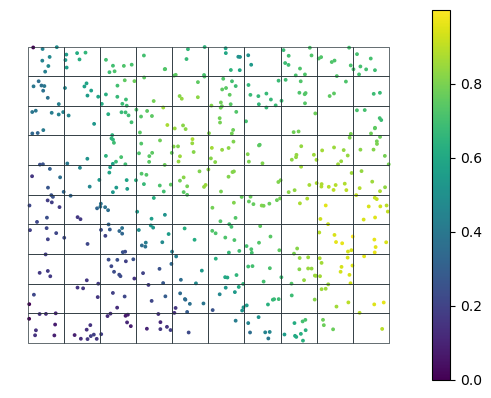

In [ ]:
#|eval: false
dc_emulator = DataCollector(fname_raster)
samples_t0 = dc_emulator.collect(sample_locs)
print(samples_t0.head())

ax = samples_t0.plot(column='value', s=3, legend=True)
gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax)
ax.axis('off');

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()